In [1]:
import warnings
warnings.filterwarnings('ignore',category=RuntimeWarning)
import xarray as xr
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import glob,os,sys
from tqdm import tqdm
import datetime
import proplot as plot
from netCDF4 import Dataset
from wrf import getvar
import celer
from scipy.ndimage import gaussian_filter
import gc
%matplotlib inline

sys.path.insert(1, '/work/08350/tg876493/stampede2/python_codes/2020_TC_CRF/dev/freddy0218/tools/')
import derive_var
import read_and_proc
import mlr

plot.rc.update({'figure.facecolor':'w','axes.labelweight':'ultralight',
                'tick.labelweight':'ultralight','gridminor.linestyle':'--','title.weight':'normal','linewidth':0.5})

### Input Guide:
CTRL: 0:95 (LT=1)

### Functions

In [2]:
#Function####################################################
import json,pickle
def nearest_index(array, value):
    idx = (np.abs(array-value)).argmin()
    return idx.values
def save_to_pickle(loc=None,var=None):
    with open(loc,"wb") as f:
        pickle.dump(var,f)
    return None

def forward_diff(arrayin=None,delta=None,axis=None,LT=1):
    result = []
    if axis==0:
        for i in range(0,arrayin.shape[axis]-LT):
            temp = (arrayin[i+LT,:]-arrayin[i,:])/(LT*delta)
            result.append(temp)
        return np.asarray(result)
    
def export_corrmap(PCAinput=None,orig_normalarray=None,orig_flatarray=None,component=4,TYPE='correlation'):
    # Adapted from eofs package
    slicer = slice(0,component)
    dt_eigenvector = PCAinput.components_[:,slicer].copy()/np.sqrt(PCAinput.explained_variance_[slicer])
    dt_eigenvector_a = dt_eigenvector-np.nanmean(dt_eigenvector,axis=0)
    ############################################
    # Center pcs and field
    ############################################
    pcs_std = np.nanstd(dt_eigenvector_a,axis=0)
    field_std = np.nanstd(orig_flatarray,axis=0)
    ############################################
    # Set the divisor.
    ############################################
    div = np.float64(dt_eigenvector_a.shape[0])
    ############################################
    # Compute the correlation map.
    ############################################
    cor = np.ma.dot(orig_flatarray.T, dt_eigenvector_a).T / div
    if TYPE=='correlation':
        cor = np.ma.masked_invalid(cor)
        cor /= np.ma.outer(pcs_std, field_std)
    else:
        cor=cor
    
    output = []
    for cornum in cor:
        output.append(cornum.reshape(orig_normalarray[0,:,:,:].shape))
    return output

import scipy
def azimuth2angle(azimuth=None):
    """
    https://math.stackexchange.com/questions/926226/conversion-from-azimuth-to-counterclockwise-angle
    """
    angletest = 450-azimuth
    for index,item in enumerate(angletest):
        if item>360:
            angletest[index] = item-360
        else:
            continue
    return angletest

def closest_index(array=None,target=None):
    return np.abs(array-target).argmin()

def polar2cartesian(outcoords, inputshape, origin):
    """Coordinate transform for converting a polar array to Cartesian coordinates. 
    inputshape is a tuple containing the shape of the polar array. origin is a
    tuple containing the x and y indices of where the origin should be in the
    output array."""

    xindex, yindex = outcoords
    x0, y0 = origin
    x = xindex - x0
    y = yindex - y0

    r = np.sqrt(x**2 + y**2)
    theta = np.arctan2(y, x)
    theta_index = np.round((theta + np.pi) * inputshape[1] / (2 * np.pi))

    return (r,theta_index)

def proc_tocart(polarfield=None,angle=None,twoD=True,twoDlv=None,standard=False):
    if twoD==True:
        PWnew = [np.asarray(polarfield)[int(twoDlv),int(np.abs(ANGLE-360).argmin()),:]]
        for i in np.linspace(0,358,359):
            PWnew.append(np.asarray(polarfield)[int(twoDlv),int(np.abs(ANGLE-i).argmin()),:])
        PWnew = np.swapaxes(np.asarray(PWnew),0,1)
        del i
        
        if standard==True:
            PWnew = (PWnew-np.nanmean(PWnew))/np.nanstd(PWnew)
        else:
            PWnew=PWnew

        test_2cartesian = scipy.ndimage.geometric_transform(PWnew, 
                                                            polar2cartesian,order=0,mode='constant',
                                                            output_shape = \
                                                            (PWnew.shape[0] * 2,PWnew.shape[0] * 2),
                                                            extra_keywords = \
                                                            {'inputshape':PWnew.shape,
                                                             'origin':(PWnew.shape[0],PWnew.shape[0])})
        #print('Finish processing')
        return ((test_2cartesian))

In [3]:
origin_path = '/scratch/06040/tg853394/tc/output/redux/maria/'
#############################################################
import json,pickle
def read_some_azimuth_fields(fileloc=None,fieldname=None):
    dict_name = {}
    for inx,obj in enumerate(fileloc):
        field_read = xr.open_dataset(obj)
        dict_name[fieldname[inx]] = field_read
    return dict_name
#########################################################################################################
ctrlvar_dict = read_some_azimuth_fields(fileloc=[origin_path+'ctl/azim_U10_0-144hr.nc'],fieldname=['U10'])
r0,r200=(nearest_index(ctrlvar_dict['U10']['U10'].radius,0),nearest_index(ctrlvar_dict['U10']['U10'].radius,200))
r300,r500=(nearest_index(ctrlvar_dict['U10']['U10'].radius,300),nearest_index(ctrlvar_dict['U10']['U10'].radius,500))

In [4]:
def display_crosssection(corrmap=None,xaxis=ctrlvar_dict['U10'].radius[:r500],
                         yaxis=None,index=None,standard=True,ax=None,rtitle=None,clv=np.linspace(-5,5,41),cticks=None,ALL=False,customtitle=None):
    if standard is True:
        toplot = np.nanmean((np.asarray(corrmap)-np.nanmean(np.asarray(corrmap)))/np.nanstd(np.asarray(corrmap)),axis=1)
    else:
        toplot = np.asarray(corrmap)
    img=ax.contourf(xaxis,yaxis,toplot,levels=clv,cmap='balance',extend='both')
    ax.colorbar(img,loc='ur',ticks=cticks)
    if ALL is False:
        ax.format(ltitle=r'PCA0'+str(index+1),rtitle=rtitle,xlabel='Distance from TC centre (km)',ylabel='Pressure (hPa)',ylim=[1000,50])
    elif ALL is True:
        ax.format(ltitle=customtitle,rtitle=rtitle,xlabel='Distance from TC centre (km)',ylabel='Pressure (hPa)',ylim=[1000,50])
    ax.yaxis.label.set_size(8.5)
    ax.xaxis.label.set_size(8.5)
    ax.tick_params(axis='both', which='major', labelsize=8)
    return ax
        #plt.gca().invert_yaxis()
        
def display_avgprofil(corrmap=None,yaxis=None,index=None,standard=True,radius=None,ax=None,xlabel=None,color=['k','r'],lw=2,alpha=0.6,ALL=False,customtitle=None):
    if standard is True:
        arrayS = (np.asarray(corrmap)-np.nanmean(np.asarray(corrmap)))/np.nanstd(np.asarray(corrmap))
    else:
        arrayS = np.asarray(corrmap)
    profilIN = np.nanmean(arrayS[:,:,radius[0]:radius[1]],axis=(1,2))
    profilOUT = np.nanmean(arrayS[:,:,radius[1]:radius[2]],axis=(1,2))
    profilavg = np.nanmean(arrayS[:,:,radius[0]:radius[2]],axis=(1,2))
    flattened = np.concatenate((profilIN,profilOUT)).flatten()
    ax.plot(profilIN,yaxis,c=color[0],lw=lw,alpha=alpha,label='0-200 km')
        #ax.plot(profilOUT,yaxis,c=color[1],lw=lw,alpha=alpha,label='200-500 km')
    if ALL is False:
        ax.format(title=r'PCA0'+str(index+1),xlabel=xlabel,ylabel='Pressure (hPa)',ylim=[1000,50],xlim=[np.min(flattened)*1.1,np.max(flattened)*1.1])
    else:
        ax.format(title=customtitle,xlabel=xlabel,ylabel='Pressure (hPa)',ylim=[1000,50],xlim=[np.min(flattened)*1.1,np.max(flattened)*1.1])
    ax.yaxis.label.set_size(8.5)
    ax.xaxis.label.set_size(8.5)
    ax.legend(loc='r',ncols=1)
    ax.tick_params(axis='both', which='major', labelsize=8) 
    return ax

def display_cart(corrmap=None,axs=None,index=None,heightindex=[6,20,32],cart_axis=None,ANGLE=None):
    #levels_u,levels_du,levels_dt=np.linspace(-3,3,31),np.linspace(-0.1,0.1,41),np.linspace(-0.08,0.08,33)
    for count,heightindx in enumerate((heightindex)):
        #maptoplot_tostand = corrmap[index][heightindx]
        toplot = np.fliplr(np.flipud((proc_tocart(corrmap,ANGLE,True,heightindx,False))))
        img = axs[count].contourf(cart_axis,cart_axis,toplot,levels=np.linspace(-np.max(np.abs(toplot))*1.05,np.max(np.abs(toplot))*1.05,21),cmap='balance',extend='both') #-.08,.08,33 (dt) -.1,.1,41 (du/dv)
        axs[count].colorbar(img,loc='b',ticks=[np.round(-np.max(np.abs(toplot))/1.5),0,np.round(np.max(np.abs(toplot))/1.5)])
        axs[count].format(xlabel='X (km)',ylabel='Y (km)',title=r'{} hPa'.format(int(coor.pres[heightindx].data)))
        axs[count].yaxis.label.set_size(8.5)
        axs[count].xaxis.label.set_size(8.5)
        axs[count].tick_params(axis='both', which='major', labelsize=8)
    return axs

In [5]:
def adjust_spines(ax, spines,offset=10):
    for loc, spine in ax.spines.items():
        if loc in spines:
            spine.set_position(('outward', offset))  # outward by 10 points
        else:
            spine.set_color('None')  # don't draw spine

    # turn off ticks where there is no spine
    if 'left' in spines:
        ax.yaxis.set_ticks_position('left')
    else:
        # no yaxis ticks
        ax.yaxis.set_ticks([])

    if 'bottom' in spines:
        ax.xaxis.set_ticks_position('bottom')
    else:
        # no xaxis ticks
        ax.xaxis.set_ticks([])

### Read files

In [6]:
path_coor = '/scratch/06040/tg853394/tc/output/redux/maria/ctl/post/U.nc'
coor = xr.open_dataset(path_coor)

In [7]:
np.abs(coor.pres-700).argmin(),np.abs(coor.pres-925).argmin(),np.abs(coor.pres-200).argmin()

(<xarray.DataArray 'pres' ()>
 array(12),
 <xarray.DataArray 'pres' ()>
 array(3),
 <xarray.DataArray 'pres' ()>
 array(32))

##### Hovmoller

In [10]:
! ls /scratch/08350/tg876493/mlr_output/exp6/dtuvw/reconstruct/nodiurnal/all

ctrl48	noir  norad


In [20]:
import importlib
importlib.reload(mlr)
path = '/scratch/08350/tg876493/mlr_output/exp6/dtuvw/reconstruct/simple-all/allrad/'

#w_hovRAD = read_forecast_makehov(sorted(glob.glob(path+'ctrl48/wrecon_48*')),sorted(glob.glob(path+'noir/ctrl48/wrecon_48*')),
#                                 timestep=48,heightlevel=3,substract=True,SIMPLER=True)
u_hovRAD = [mlr.read_forecast_makehov(sorted(glob.glob(path+'ctrl48/vrecon_48*')),None,
                                 timestep=48,heightlevel=hlv,substract=True,SIMPLER=True) for hlv in [3,12,32]]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:03<00:00,  3.30it/s]


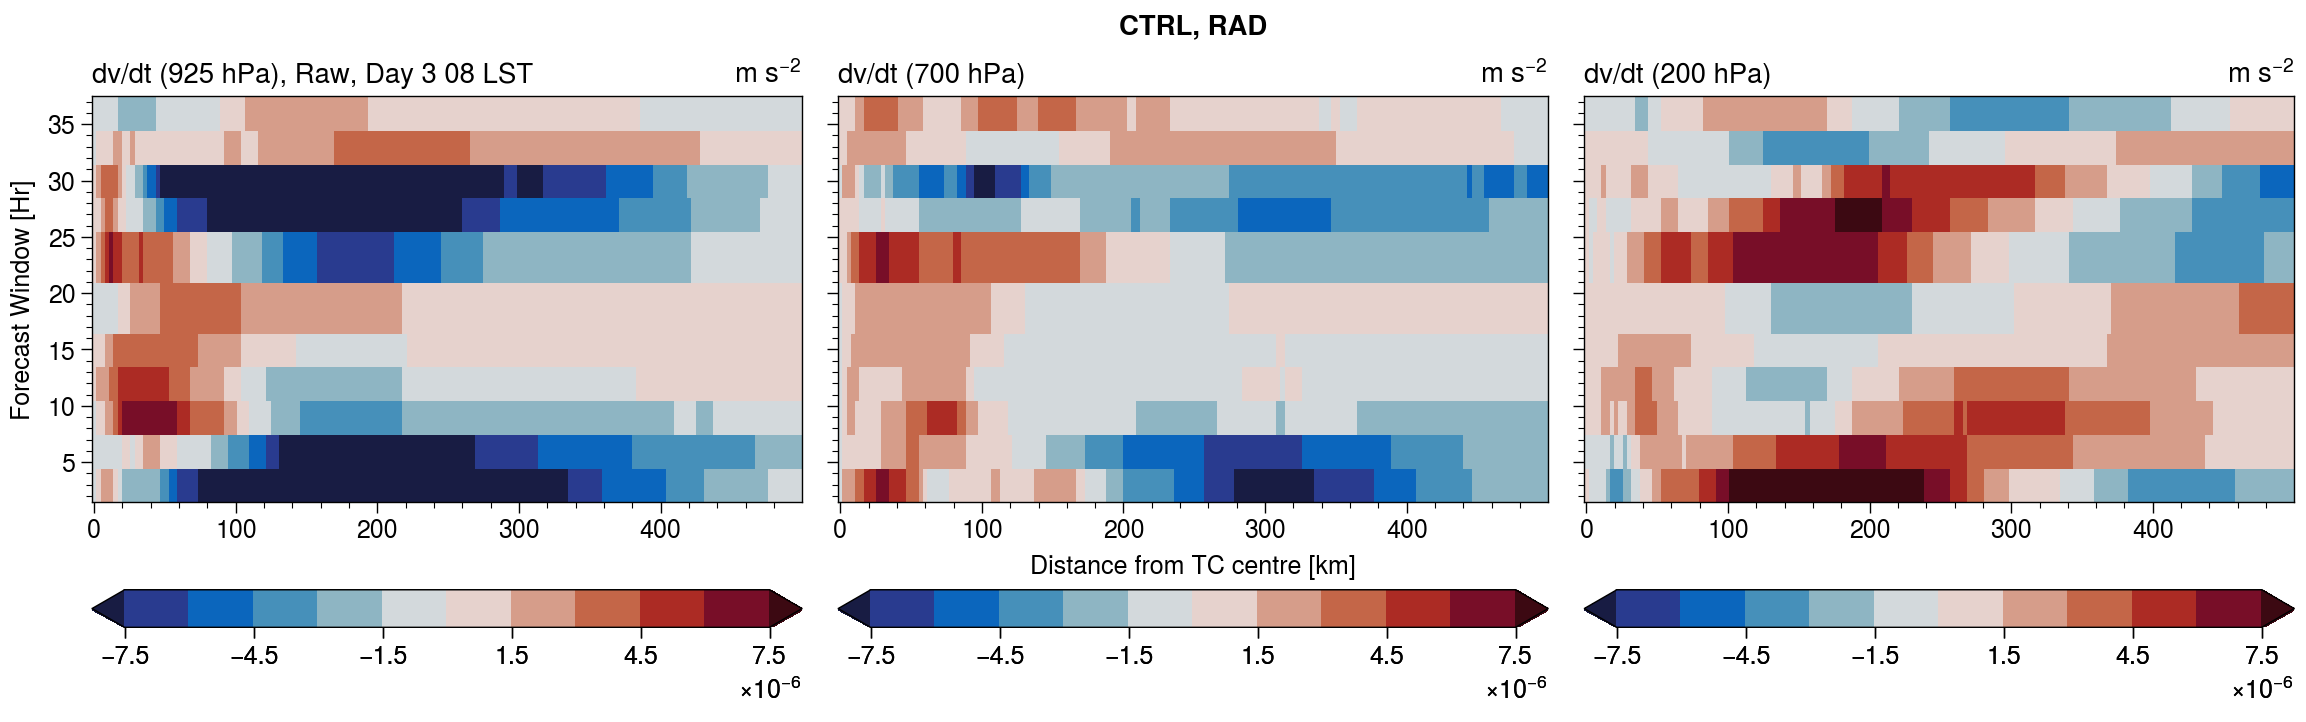

In [21]:
#dwdt: np.linspace(-0.5e-6,0.5e-6,41)/np.linspace(-3,3,31) / dudt: np.linspace(-8e-6,8e-6,41)
fig,axs = plot.subplots(ncols=3,nrows=1,axwidth=3.55,refaspect=1.751,sharey=3)

img = axs[0].pcolormesh(ctrlvar_dict['U10'].radius[:r500],[3,6,9,12,15,18,24,27,30,33,36],
             (u_hovRAD[0]),vmin=-8e-6,vmax=8e-6,cmap='balance',extend='both') 
#levels=np.linspace(-0.5e-6,0.5e-6,41)
axs[0].colorbar(img,loc='b')
axs[0].format(xlabel='Distance from TC centre [km]',ylabel='Forecast Window [Hr]',ltitle='dv/dt (925 hPa), Raw, Day 3 08 LST',\
              rtitle='m s$^{-2}$',suptitle='CTRL, RAD')

img = axs[1].pcolormesh(ctrlvar_dict['U10'].radius[:r500],[3,6,9,12,15,18,24,27,30,33,36],
             (u_hovRAD[1]),vmin=-8e-6,vmax=8e-6,cmap='balance',extend='both') 
axs[1].colorbar(img,loc='b')
axs[1].format(xlabel='Distance from TC centre [km]',ylabel='Forecast Window [Hr]',ltitle='dv/dt (700 hPa)',\
              rtitle='m s$^{-2}$')

img = axs[2].pcolormesh(ctrlvar_dict['U10'].radius[:r500],[3,6,9,12,15,18,24,27,30,33,36],
             (u_hovRAD[2]),vmin=-8e-6,vmax=8e-6,cmap='balance',extend='both') 
axs[2].colorbar(img,loc='b')
axs[2].format(xlabel='Distance from TC centre [km]',ylabel='Forecast Window [Hr]',ltitle='dv/dt (200 hPa)',\
              rtitle='m s$^{-2}$')
plt.savefig('../0105/hov/dvdt_ctrl_rad_hovN.png',dpi=400)
plt.show()

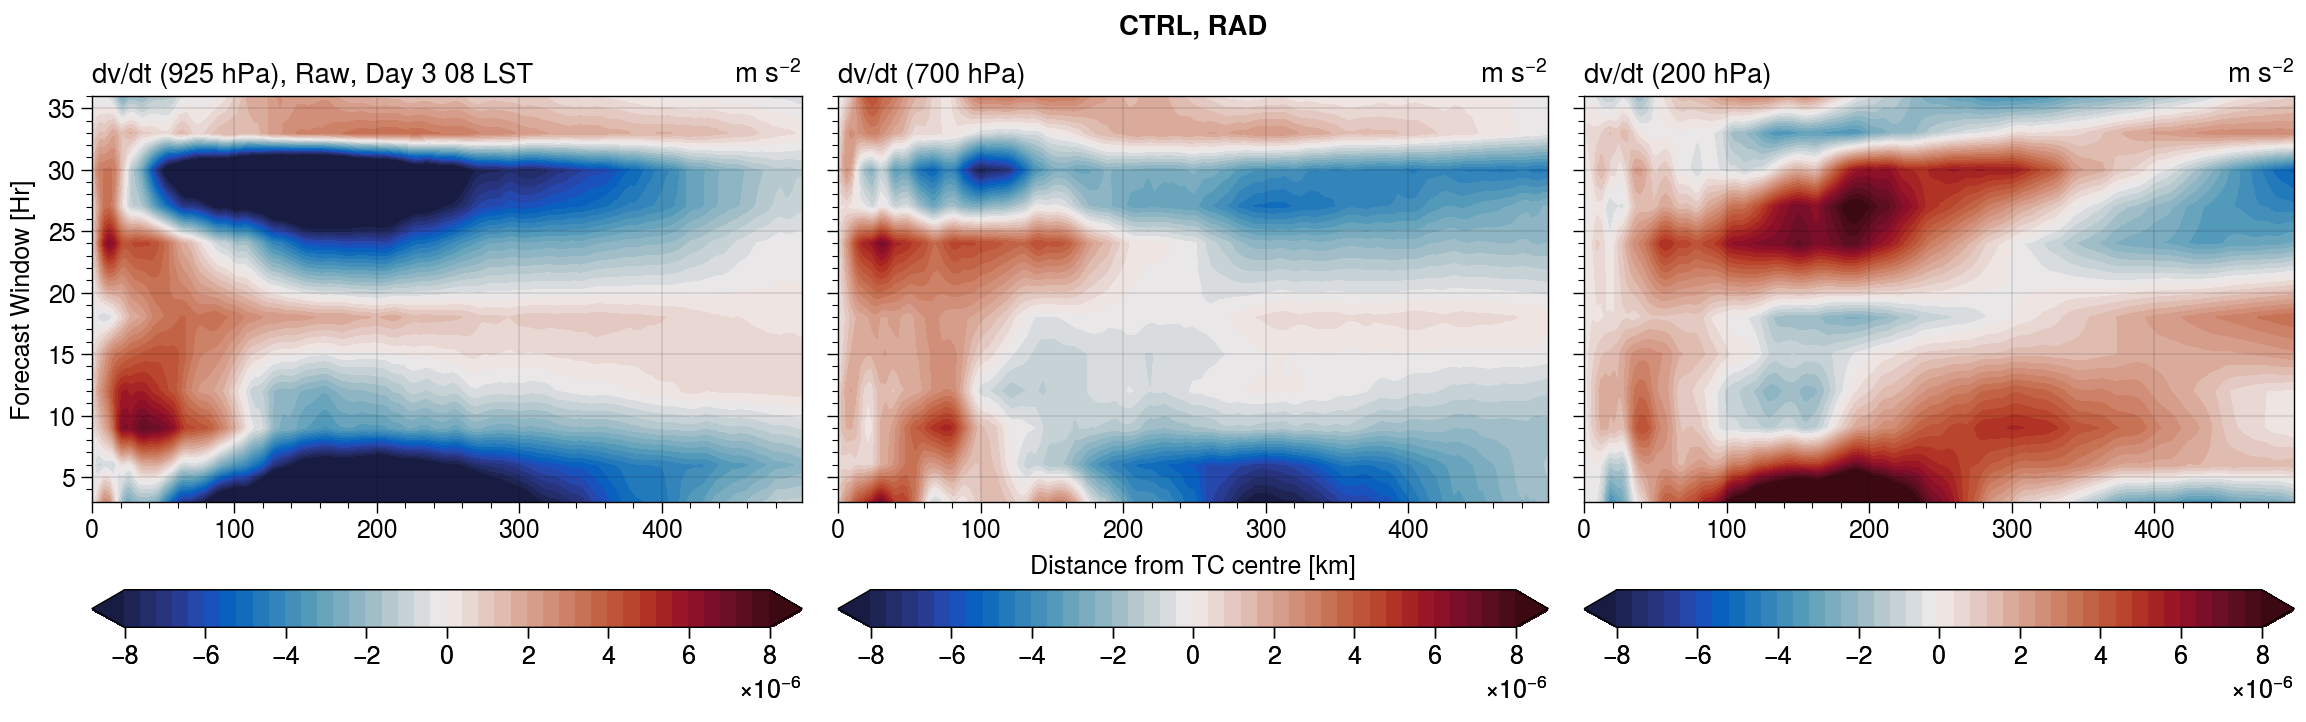

In [22]:
#dwdt: np.linspace(-0.5e-6,0.5e-6,41)/np.linspace(-3,3,31)
fig,axs = plot.subplots(ncols=3,nrows=1,axwidth=3.55,refaspect=1.751,sharey=3)

img = axs[0].contourf(ctrlvar_dict['U10'].radius[:r500],[3,6,9,12,15,18,24,27,30,33,36],
             (u_hovRAD[0]),levels=np.linspace(-8e-6,8e-6,41),cmap='balance',extend='both') 
#levels=np.linspace(-0.5e-6,0.5e-6,41)
axs[0].colorbar(img,loc='b')
axs[0].format(xlabel='Distance from TC centre [km]',ylabel='Forecast Window [Hr]',ltitle='dv/dt (925 hPa), Raw, Day 3 08 LST',\
              rtitle='m s$^{-2}$',suptitle='CTRL, RAD')

img = axs[1].contourf(ctrlvar_dict['U10'].radius[:r500],[3,6,9,12,15,18,24,27,30,33,36],
             (u_hovRAD[1]),levels=np.linspace(-8e-6,8e-6,41),cmap='balance',extend='both') 
axs[1].colorbar(img,loc='b')
axs[1].format(xlabel='Distance from TC centre [km]',ylabel='Forecast Window [Hr]',ltitle='dv/dt (700 hPa)',\
              rtitle='m s$^{-2}$')

img = axs[2].contourf(ctrlvar_dict['U10'].radius[:r500],[3,6,9,12,15,18,24,27,30,33,36],
             (u_hovRAD[2]),levels=np.linspace(-8e-6,8e-6,41),cmap='balance',extend='both') 
axs[2].colorbar(img,loc='b')
axs[2].format(xlabel='Distance from TC centre [km]',ylabel='Forecast Window [Hr]',ltitle='dv/dt (200 hPa)',\
              rtitle='m s$^{-2}$')
plt.savefig('../0105/hov/dvdt_ctrl_rad_hov_contourN.png',dpi=400)
plt.show()

##### CFADs

In [32]:
ctrlvar_dict = read_and_proc.read_some_azimuth_fields(fileloc=[origin_path+'ctl/azim_U_0-144hr.nc'],fieldname=['U'])
ctrl_t2,ctrl_t4 = nearest_index(ctrlvar_dict['U']['U'].time/24,1)-1,nearest_index(ctrlvar_dict['U']['U'].time/24,5)-1
r300,r500=nearest_index(ctrlvar_dict['U']['U'].radius,200),nearest_index(ctrlvar_dict['U']['U'].radius,500)

In [83]:
path = '/scratch/08350/tg876493/mlr_output/exp6/dtuvw/reconstruct/all/'
IRup_median = read_forecast_makeprofile(sorted(glob.glob(path+'ctrl48/wrecon_48*')),sorted(glob.glob(path+'noir/ctrl48/wrecon_48*')),SIMPLER=True,\
                                   TYPE='all',radius=[0,r300],percentile=50,mean='No')

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:04<00:00,  2.57it/s]


In [130]:
IRup_median = read_forecast_makeprofile(sorted(glob.glob(path+'ctrl48/wrecon_48*')),sorted(glob.glob(path+'noir/ctrl48/wrecon_48*')),SIMPLER=True,\
                                   TYPE='all',radius=[0,r300],percentile=50,mean='No')
IRu_median = read_forecast_makeprofile(sorted(glob.glob(path+'ctrl48/urecon_48*')),sorted(glob.glob(path+'noir/ctrl48/urecon_48*')),SIMPLER=True,\
                                   TYPE='all',radius=[0,r300],percentile=50,mean='No')
IRv_median = read_forecast_makeprofile(sorted(glob.glob(path+'ctrl48/vrecon_48*')),sorted(glob.glob(path+'noir/ctrl48/vrecon_48*')),SIMPLER=True,\
                                   TYPE='all',radius=[0,r300],percentile=50,mean='No')

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:05<00:00,  2.01it/s]


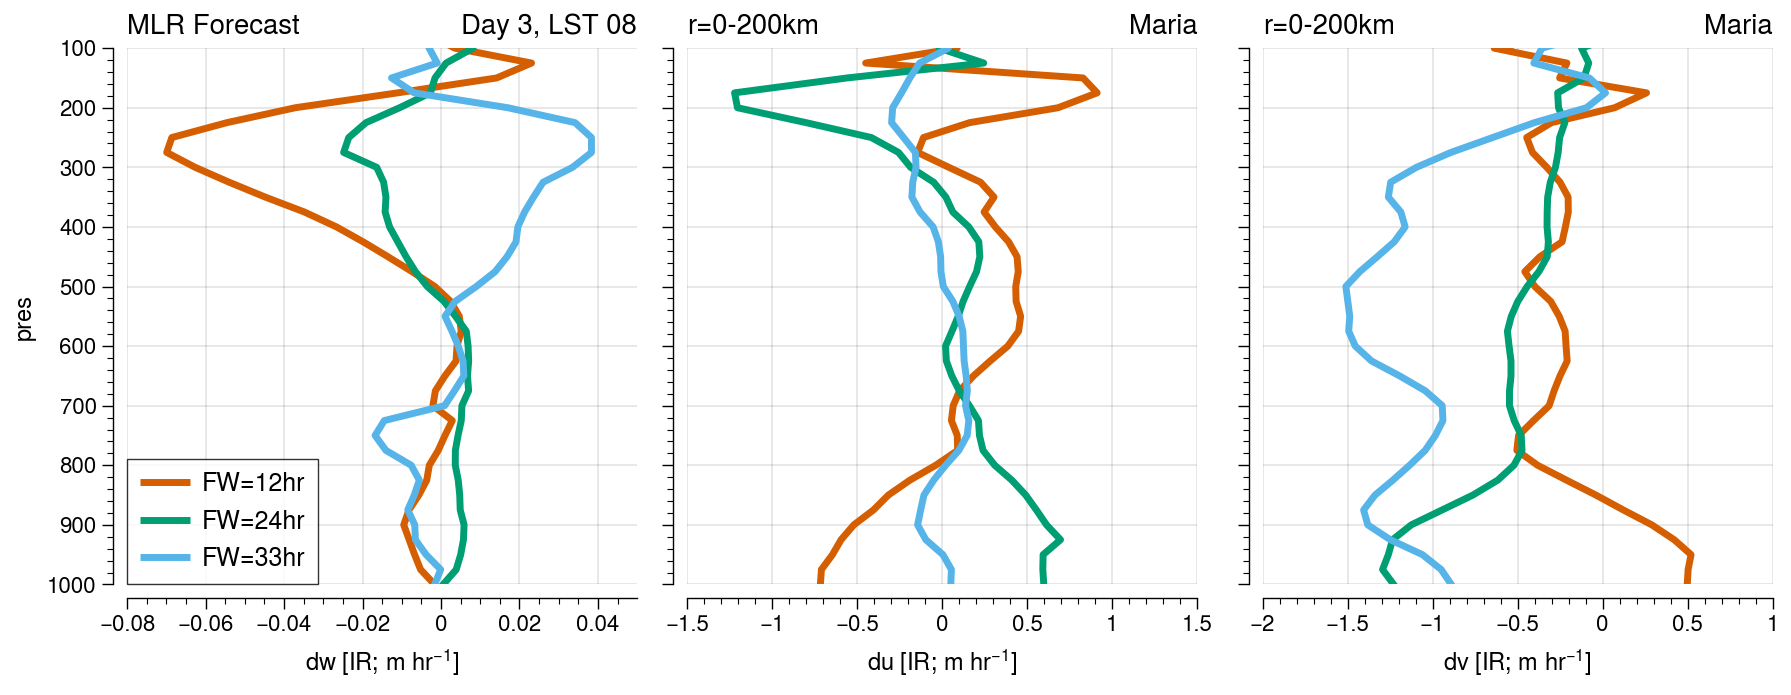

In [136]:
fig,axs = plot.subplots(ncols=3,nrows=1,axwidth=2.55,refaspect=0.951,sharey=3,sharex=0)
axs[0].plot(IRup_median[3]*(10*60)**2,coor.pres,color='C1',lw=2.5,label='FW=12hr')
axs[0].plot(IRup_median[6]*(10*60)**2,coor.pres,color='C2',lw=2.5,label='FW=24hr')
axs[0].plot(IRup_median[9]*(10*60)**2,coor.pres,color='C5',lw=2.5,label='FW=33hr')
axs[0].legend(loc='ll',ncols=1)
axs[0].format(ylim=[1000,100],xlim=[-0.08,0.05],xlabel='dw [IR; m hr$^{-1}$]',ylabel='Pressure (hPa)',ltitle='MLR Forecast',rtitle='Day 3, LST 08')
axs[0].yaxis.label.set_size(8.5)
axs[0].xaxis.label.set_size(8.5)
axs[0].tick_params(axis='both', which='major', labelsize=8)
adjust_spines(axs[0],['left','bottom'],5)

axs[1].plot(IRu_median[3]*(10*60)**2,coor.pres,color='C1',lw=2.5,label='FW=12hr')
axs[1].plot(IRu_median[6]*(10*60)**2,coor.pres,color='C2',lw=2.5,label='FW=24hr')
axs[1].plot(IRu_median[9]*(10*60)**2,coor.pres,color='C5',lw=2.5,label='FW=33hr')
axs[1].format(ylim=[1000,100],xlim=[-1.5,1.5],xlabel='du [IR; m hr$^{-1}$]',ltitle='r=0-200km',rtitle='Maria')
axs[1].yaxis.label.set_size(8.5)
axs[1].xaxis.label.set_size(8.5)
axs[1].tick_params(axis='both', which='major', labelsize=8)
adjust_spines(axs[1],['left','bottom'],5)

axs[2].plot(IRv_median[3]*(10*60)**2,coor.pres,color='C1',lw=2.5,label='FW=12hr')
axs[2].plot(IRv_median[6]*(10*60)**2,coor.pres,color='C2',lw=2.5,label='FW=24hr')
axs[2].plot(IRv_median[9]*(10*60)**2,coor.pres,color='C5',lw=2.5,label='FW=33hr')
axs[2].format(ylim=[1000,100],xlim=[-2,1],xlabel='dv [IR; m hr$^{-1}$]',ltitle='r=0-200km',rtitle='Maria')
axs[2].yaxis.label.set_size(8.5)
axs[2].xaxis.label.set_size(8.5)
axs[2].tick_params(axis='both', which='major', labelsize=8)
adjust_spines(axs[2],['left','bottom'],5)
plt.savefig('../1227/dwdtdudt_profil_FW.png',dpi=400)
plt.show()

In [135]:
IRup_median_ncrf36 = read_forecast_makeprofile(sorted(glob.glob(path+'ncrf36_48/wrecon_NCRF36_48*')),sorted(glob.glob(path+'noir/ncrf36_48/wrecon_NCRF36_48*')),SIMPLER=True,\
                                   TYPE='all',radius=[0,r300],percentile=50,mean='No')
IRu_median_ncrf36 = read_forecast_makeprofile(sorted(glob.glob(path+'ncrf36_48/urecon_NCRF36_48*')),sorted(glob.glob(path+'noir/ncrf36_48/urecon_NCRF36_48*')),SIMPLER=True,\
                                   TYPE='all',radius=[0,r300],percentile=50,mean='No')
IRv_median_ncrf36 = read_forecast_makeprofile(sorted(glob.glob(path+'ncrf36_48/vrecon_NCRF36_48*')),sorted(glob.glob(path+'noir/ncrf36_48/vrecon_NCRF36_48*')),SIMPLER=True,\
                                   TYPE='all',radius=[0,r300],percentile=50,mean='No')

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:06<00:00,  1.79it/s]


In [ ]:
fig,axs = plot.subplots(ncols=3,nrows=1,axwidth=2.55,refaspect=0.951,sharey=3,sharex=0)
axs[0].plot(IRup_median_ncrf36[3]*(10*60)**2,coor.pres,color='C1',lw=2.5,label='FW=12hr')
axs[0].plot(IRup_median_ncrf36[6]*(10*60)**2,coor.pres,color='C2',lw=2.5,label='FW=24hr')
axs[0].plot(IRup_median_ncrf36[9]*(10*60)**2,coor.pres,color='C5',lw=2.5,label='FW=33hr')
axs[0].legend(loc='ll',ncols=1)
axs[0].format(ylim=[1000,100],xlim=[-0.08,0.05],xlabel='dw [IR; m hr$^{-1}$]',ylabel='Pressure (hPa)',ltitle='MLR Forecast [NCRF36]',rtitle='Day 3, LST 08')
axs[0].yaxis.label.set_size(8.5)
axs[0].xaxis.label.set_size(8.5)
axs[0].tick_params(axis='both', which='major', labelsize=8)
adjust_spines(axs[0],['left','bottom'],5)

axs[1].plot(IRu_median_ncrf36[3]*(10*60)**2,coor.pres,color='C1',lw=2.5,label='FW=12hr')
axs[1].plot(IRu_median_ncrf36[6]*(10*60)**2,coor.pres,color='C2',lw=2.5,label='FW=24hr')
axs[1].plot(IRu_median_ncrf36[9]*(10*60)**2,coor.pres,color='C5',lw=2.5,label='FW=33hr')
axs[1].format(ylim=[1000,100],xlim=[-1.5,1.5],xlabel='du [IR; m hr$^{-1}$]',ltitle='r=0-200km',rtitle='Maria')
axs[1].yaxis.label.set_size(8.5)
axs[1].xaxis.label.set_size(8.5)
axs[1].tick_params(axis='both', which='major', labelsize=8)
adjust_spines(axs[1],['left','bottom'],5)

axs[2].plot(IRv_median_ncrf36[3]*(10*60)**2,coor.pres,color='C1',lw=2.5,label='FW=12hr')
axs[2].plot(IRv_median_ncrf36[6]*(10*60)**2,coor.pres,color='C2',lw=2.5,label='FW=24hr')
axs[2].plot(IRv_median_ncrf36[9]*(10*60)**2,coor.pres,color='C5',lw=2.5,label='FW=33hr')
axs[2].format(ylim=[1000,100],xlim=[-3.5,2.5],xlabel='dv [IR; m hr$^{-1}$]',ltitle='r=0-200km',rtitle='Maria')
axs[2].yaxis.label.set_size(8.5)
axs[2].xaxis.label.set_size(8.5)
axs[2].tick_params(axis='both', which='major', labelsize=8)
adjust_spines(axs[1],['left','bottom'],5)
plt.savefig('../1227/dwdtdudt_ncrf36_profil_FW.png',dpi=400)
plt.show()

#### Old codes

In [8]:
def read_forecast_and_output(filelist=None,filelist_aux=None,SIMPLER=True,subtract=True):
    from copy import deepcopy
    OUTPUT = []
    for i in tqdm(range(len(filelist))):
        with open(filelist[i],'rb') as f: temp = deepcopy(pickle.load(f))
        if filelist_aux:
            with open(filelist_aux[i],'rb') as f: tempaux = deepcopy(pickle.load(f))
        else:
            tempaux = 0
        
        if SIMPLER is True:
            if subtract is True:
                ans = temp-tempaux
            else:
                ans = temp
            tempTIME = ans.reshape(39,360,167)
        else:
            tempTIME,tempTIME_aux = temp[int(timestep),:].reshape(39,360,167),tempaux[int(timestep),:].reshape(39,360,167)
        OUTPUT.append(tempTIME)
        del temp,tempaux,tempTIME
        gc.collect()
    return OUTPUT

In [9]:
path = '/scratch/08350/tg876493/mlr_output/exp6/dtuvw/reconstruct/simple-all/all/'
#allheat
W_MLRforecast = read_forecast_and_output(sorted(glob.glob(path+'ctrl48/wrecon_48*')),None,True,False)
U_MLRforecast = read_forecast_and_output(sorted(glob.glob(path+'ctrl48/urecon_48*')),None,True,False)
V_MLRforecast = read_forecast_and_output(sorted(glob.glob(path+'ctrl48/vrecon_48*')),None,True,False)
RECON_dict = {'u':U_MLRforecast,'w':W_MLRforecast,'v':V_MLRforecast}
del U_MLRforecast,W_MLRforecast,V_MLRforecast
gc.collect()

path = '/scratch/08350/tg876493/mlr_output/exp6/dtuvw/reconstruct/simple-all/uvw/'
#allheat
W_MLRforecast = read_forecast_and_output(sorted(glob.glob(path+'ctrl48/wrecon_48*')),None,True,False)
U_MLRforecast = read_forecast_and_output(sorted(glob.glob(path+'ctrl48/urecon_48*')),None,True,False)
V_MLRforecast = read_forecast_and_output(sorted(glob.glob(path+'ctrl48/vrecon_48*')),None,True,False)
UVW_dict = {'u':U_MLRforecast,'w':W_MLRforecast,'v':V_MLRforecast}
del U_MLRforecast,W_MLRforecast,V_MLRforecast
gc.collect()

path = '/scratch/08350/tg876493/mlr_output/exp6/dtuvw/reconstruct/simple-all/allheat/'
#allheat
W_MLRforecast = read_forecast_and_output(sorted(glob.glob(path+'ctrl48/wrecon_48*')),None,True,False)
U_MLRforecast = read_forecast_and_output(sorted(glob.glob(path+'ctrl48/urecon_48*')),None,True,False)
V_MLRforecast = read_forecast_and_output(sorted(glob.glob(path+'ctrl48/vrecon_48*')),None,True,False)
HEAT_dict = {'u':U_MLRforecast,'w':W_MLRforecast,'v':V_MLRforecast}
del U_MLRforecast,W_MLRforecast,V_MLRforecast

path = '/scratch/08350/tg876493/mlr_output/exp6/dtuvw/reconstruct/simple-all/allrad/'
#allheat
W_MLRforecast = read_forecast_and_output(sorted(glob.glob(path+'ctrl48/wrecon_48*')),None,True,False)
U_MLRforecast = read_forecast_and_output(sorted(glob.glob(path+'ctrl48/urecon_48*')),None,True,False)
V_MLRforecast = read_forecast_and_output(sorted(glob.glob(path+'ctrl48/vrecon_48*')),None,True,False)
RAD_dict = {'u':U_MLRforecast,'w':W_MLRforecast,'v':V_MLRforecast}
del U_MLRforecast,W_MLRforecast,V_MLRforecast

path = '/scratch/08350/tg876493/mlr_output/exp6/dtuvw/reconstruct/simple-all/resi/'
#allheat
W_MLRforecast = read_forecast_and_output(sorted(glob.glob(path+'ctrl48/wrecon_48*')),None,True,False)
U_MLRforecast = read_forecast_and_output(sorted(glob.glob(path+'ctrl48/urecon_48*')),None,True,False)
V_MLRforecast = read_forecast_and_output(sorted(glob.glob(path+'ctrl48/vrecon_48*')),None,True,False)
RESI_dict = {'u':U_MLRforecast,'w':W_MLRforecast,'v':V_MLRforecast}
del U_MLRforecast,W_MLRforecast,V_MLRforecast

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:05<00:00,  2.16it/s]


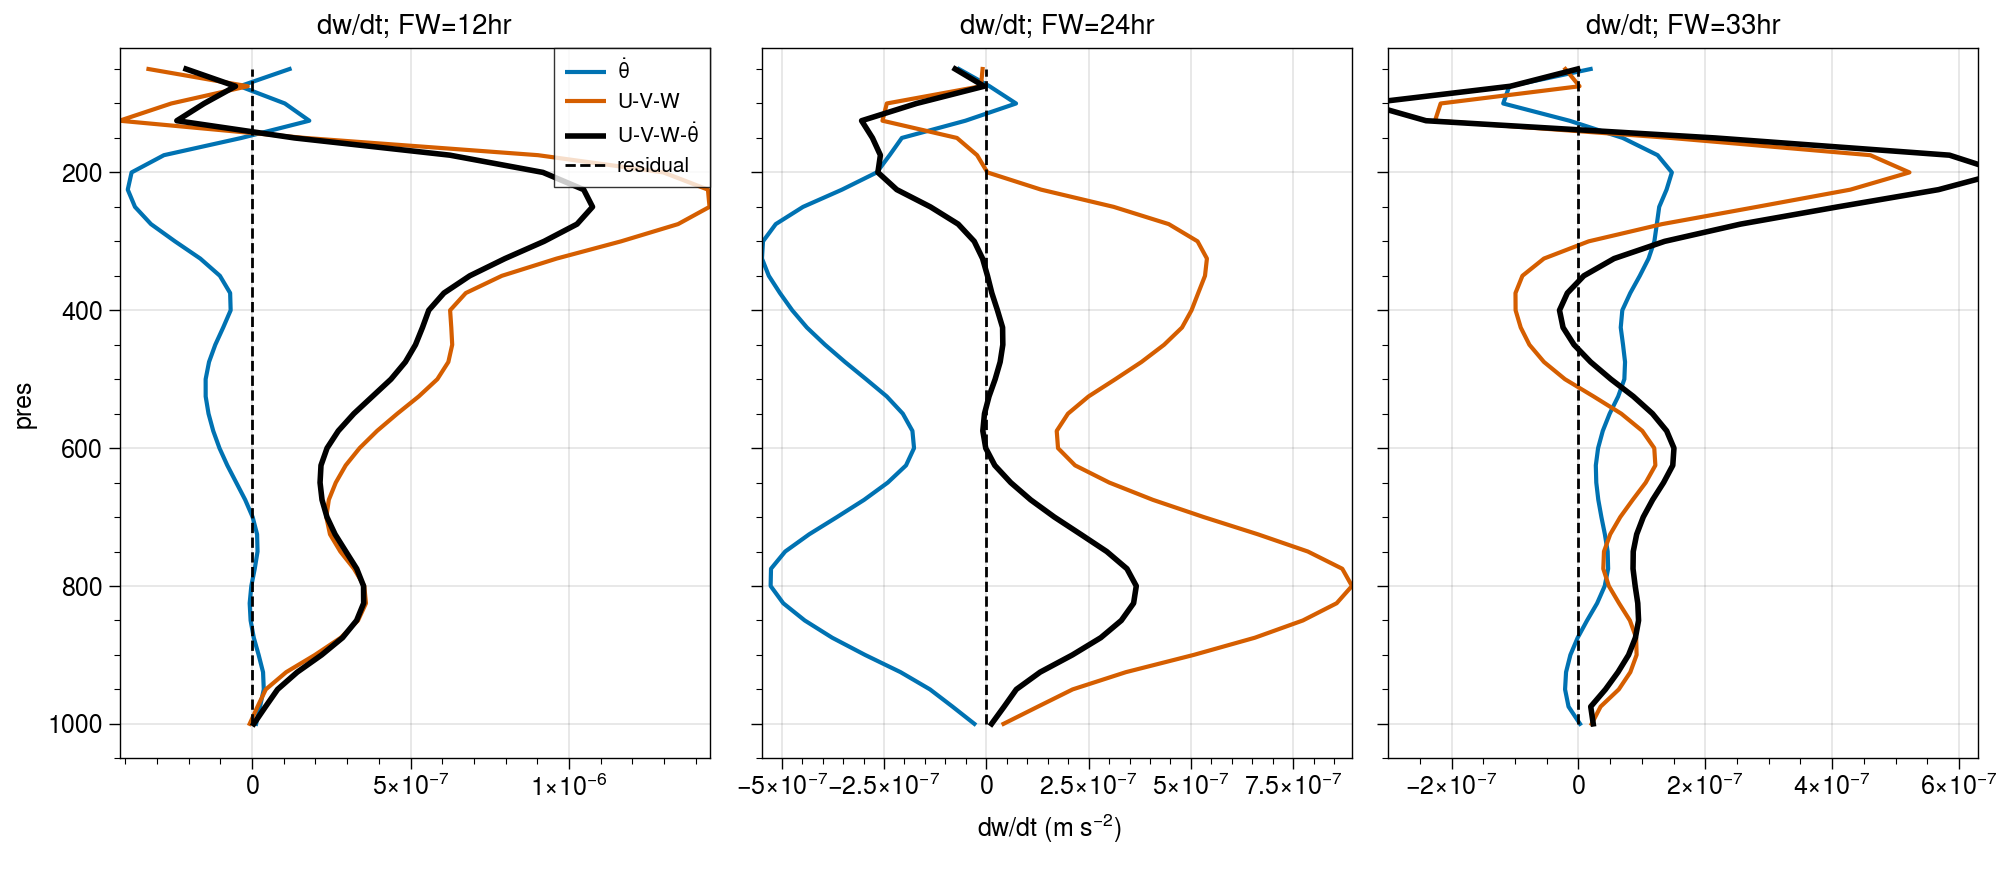

In [87]:
index =[3,6,9]
var='w'
#A = np.abs(np.nanmean(RECON_dict[var][index][:,:,0:],axis=(1,2))-\
#         np.nanmean(RAD_dict[var][index][:,:,0:]+RESI_dict[var][index][:,:,0:]+UVW_dict[var][index][:,:,0:],axis=(1,2)))

fig,axs = plot.subplots(ncols=3,nrows=1,axwidth=2.95,refaspect=0.831)
axs[0].plot((np.nanmean(HEAT_dict[var][index[0]][:,:,0:],axis=(1,2))),coor.pres,label=r'$\dot{\theta}$')
axs[0].plot(np.nanmean(UVW_dict[var][index[0]][:,:,0:],axis=(1,2)),coor.pres,label=r'U-V-W')
axs[0].plot(np.nanmean(RECON_dict[var][index[0]][:,:,0:],axis=(1,2)),coor.pres,c='k',lw=2,label=r'U-V-W-$\dot{\theta}$')
#plt.plot((np.nanmean(RECON_dict[var][index][:,:,0:67],axis=(1,2))-\
#         np.nanmean(RAD_dict[var][index][:,:,0:67]+RESI_dict[var][index][:,:,0:67]+UVW_dict[var][index][:,:,0:67],axis=(1,2))),coor.pres,c='k',lw=1,ls='--')
axs[0].plot((np.nanmean(RECON_dict[var][index[0]][:,:,0:],axis=(1,2))-\
         np.nanmean(HEAT_dict[var][index[0]][:,:,0:]+UVW_dict[var][index[0]][:,:,0:],axis=(1,2))),coor.pres,c='k',lw=1,ls='--',label='residual')
#plt.plot((np.nanmean(HEAT_dict[var][index][:,:,0:67],axis=(1,2))-\
#         np.nanmean(RAD_dict[var][index][:,:,0:67]+RESI_dict[var][index][:,:,0:67],axis=(1,2))),coor.pres,c='k',lw=1,ls='--')
#plt.plot(np.nanmean(RECON_dict[var][index],axis=(1,2)),coor.pres,c='k',lw=2) #+RESI_dict[var][index][:,:,0:67]
axs[0].legend(loc='ur',ncols=1,prop={'size':7.5})
axs[0].format(xlabel='d'+str(var)+'/dt (m s$^{-2}$)',ylabel='Pressure (hPa)',title='d'+str(var)+'/dt; FW=12hr',ylim=[1050,20],xformatter='sci')

axs[1].plot((np.nanmean(HEAT_dict[var][index[1]][:,:,0:],axis=(1,2))),coor.pres,label=r'$\dot{\theta}$')
axs[1].plot(np.nanmean(UVW_dict[var][index[1]][:,:,0:],axis=(1,2)),coor.pres,label=r'U-V-W')
axs[1].plot(np.nanmean(RECON_dict[var][index[1]][:,:,0:],axis=(1,2)),coor.pres,c='k',lw=2,label=r'U-V-W-$\dot{\theta}$')
#plt.plot((np.nanmean(RECON_dict[var][index][:,:,0:67],axis=(1,2))-\
#         np.nanmean(RAD_dict[var][index][:,:,0:67]+RESI_dict[var][index][:,:,0:67]+UVW_dict[var][index][:,:,0:67],axis=(1,2))),coor.pres,c='k',lw=1,ls='--')
axs[1].plot((np.nanmean(RECON_dict[var][index[1]][:,:,0:],axis=(1,2))-\
         np.nanmean(HEAT_dict[var][index[1]][:,:,0:]+UVW_dict[var][index[1]][:,:,0:],axis=(1,2))),coor.pres,c='k',lw=1,ls='--',label='residual')
axs[1].format(title='d'+str(var)+'/dt; FW=24hr',xformatter='sci')
axs[1].invert_xaxis()

axs[2].plot((np.nanmean(HEAT_dict[var][index[2]][:,:,0:],axis=(1,2))),coor.pres,label=r'$\dot{\theta}$')
axs[2].plot(np.nanmean(UVW_dict[var][index[2]][:,:,0:],axis=(1,2)),coor.pres,label=r'U-V-W')
axs[2].plot(np.nanmean(RECON_dict[var][index[2]][:,:,0:],axis=(1,2)),coor.pres,c='k',lw=2,label=r'U-V-W-$\dot{\theta}$')
#plt.plot((np.nanmean(RECON_dict[var][index][:,:,0:67],axis=(1,2))-\
#         np.nanmean(RAD_dict[var][index][:,:,0:67]+RESI_dict[var][index][:,:,0:67]+UVW_dict[var][index][:,:,0:67],axis=(1,2))),coor.pres,c='k',lw=1,ls='--')
axs[2].plot((np.nanmean(RECON_dict[var][index[2]][:,:,0:],axis=(1,2))-\
         np.nanmean(HEAT_dict[var][index[2]][:,:,0:]+UVW_dict[var][index[2]][:,:,0:],axis=(1,2))),coor.pres,c='k',lw=1,ls='--',label='residual')
axs[2].format(title='d'+str(var)+'/dt; FW=33hr',xformatter='sci',xlim=[-3e-7,6.3e-7])
plt.savefig('./proc_fig/0118/uvw-dt/d'+str(var)+'dt',dpi=400)
plt.show()

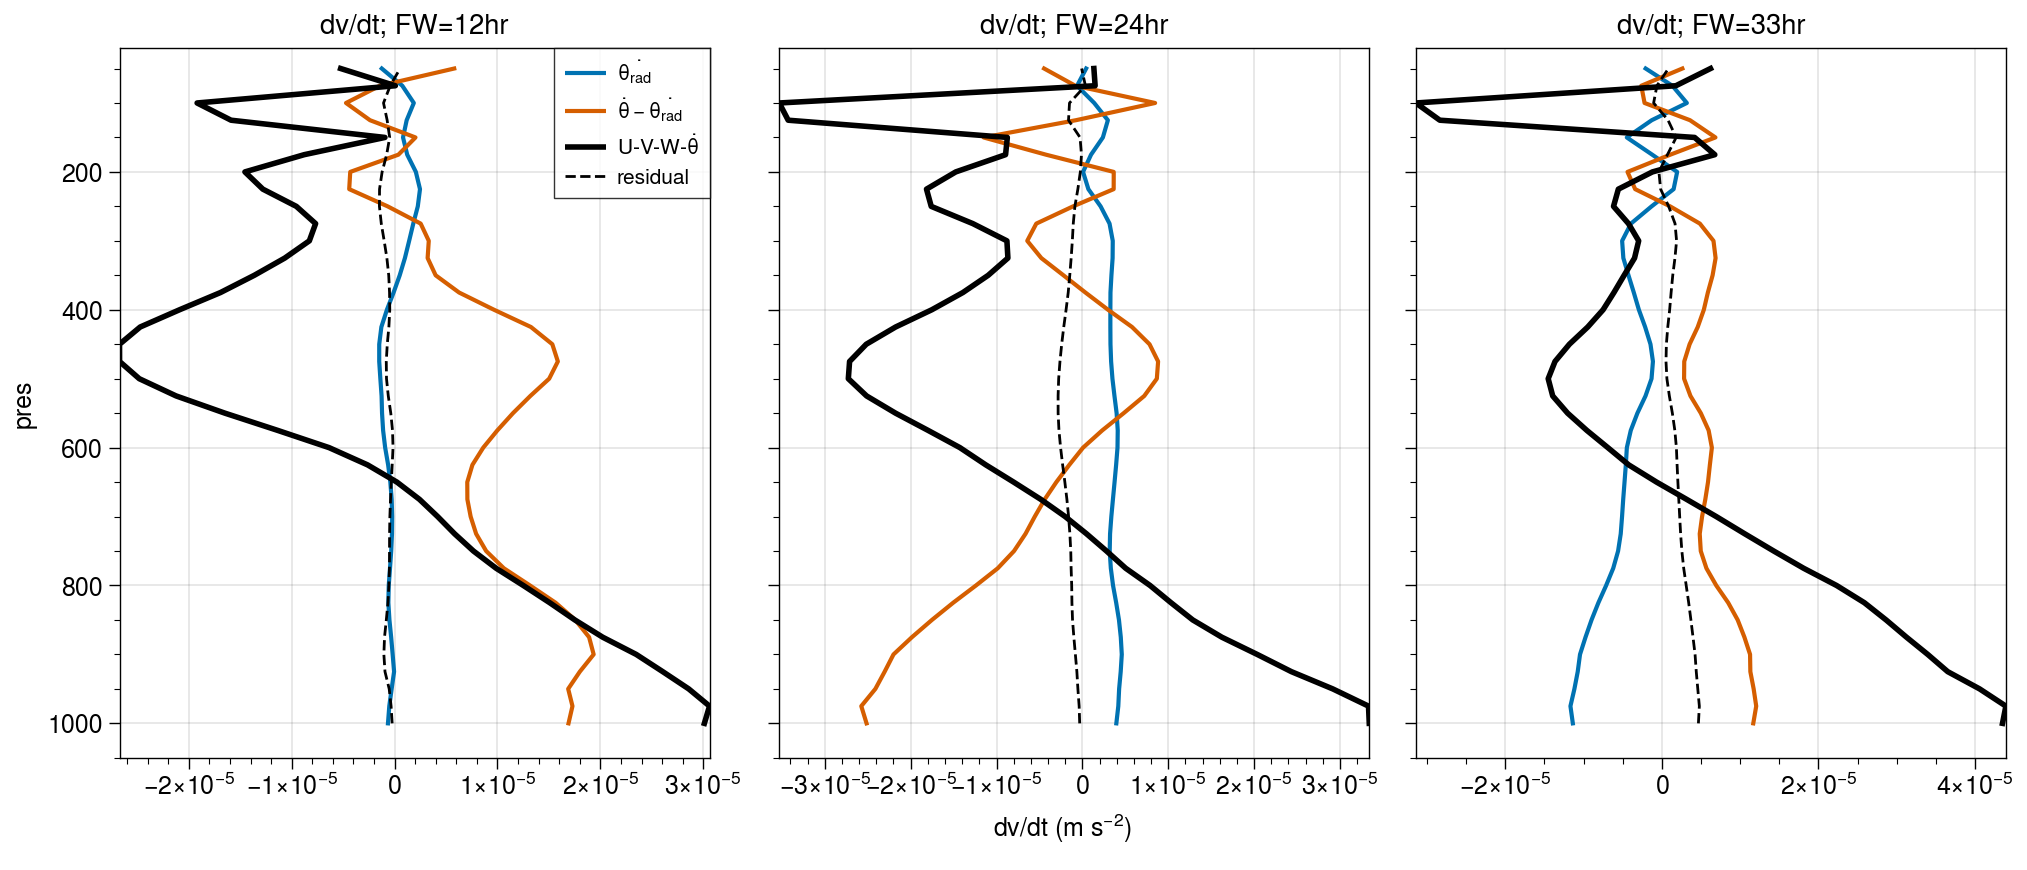

In [89]:
index =[3,6,9]
var='v'
#A = np.abs(np.nanmean(RECON_dict[var][index][:,:,0:],axis=(1,2))-\
#         np.nanmean(RAD_dict[var][index][:,:,0:]+RESI_dict[var][index][:,:,0:]+UVW_dict[var][index][:,:,0:],axis=(1,2)))

fig,axs = plot.subplots(ncols=3,nrows=1,axwidth=2.95,refaspect=0.831)
axs[0].plot((np.nanmean(RAD_dict[var][index[0]][:,:,0:],axis=(1,2))),coor.pres,label=r'$\dot{\theta_{rad}}$')
axs[0].plot(np.nanmean(RESI_dict[var][index[0]][:,:,0:],axis=(1,2)),coor.pres,label=r'$\dot{\theta}-\dot{\theta_{rad}}$')
axs[0].plot(np.nanmean(RECON_dict[var][index[0]][:,:,0:],axis=(1,2)),coor.pres,c='k',lw=2,label=r'U-V-W-$\dot{\theta}$')
axs[0].plot((np.nanmean(RECON_dict[var][index[0]][:,:,0:],axis=(1,2))-\
         np.nanmean(RAD_dict[var][index[0]][:,:,0:]+RESI_dict[var][index[0]][:,:,0:]+UVW_dict[var][index[0]][:,:,0:],axis=(1,2))),coor.pres,c='k',lw=1,ls='--',label='residual')
#axs[0].plot((np.nanmean(RECON_dict[var][index[0]][:,:,0:],axis=(1,2))-\
#         np.nanmean(HEAT_dict[var][index[0]][:,:,0:]+UVW_dict[var][index[0]][:,:,0:],axis=(1,2))),coor.pres,c='k',lw=1,ls='--',label='residual')
#plt.plot((np.nanmean(HEAT_dict[var][index][:,:,0:67],axis=(1,2))-\
#         np.nanmean(RAD_dict[var][index][:,:,0:67]+RESI_dict[var][index][:,:,0:67],axis=(1,2))),coor.pres,c='k',lw=1,ls='--')
#plt.plot(np.nanmean(RECON_dict[var][index],axis=(1,2)),coor.pres,c='k',lw=2) #+RESI_dict[var][index][:,:,0:67]
axs[0].legend(loc='ur',ncols=1,prop={'size':7.5})
axs[0].format(xlabel='d'+str(var)+'/dt (m s$^{-2}$)',ylabel='Pressure (hPa)',title='d'+str(var)+'/dt; FW=12hr',ylim=[1050,20],xformatter='sci')
axs[0].invert_xaxis()

axs[1].plot((np.nanmean(RAD_dict[var][index[1]][:,:,0:],axis=(1,2))),coor.pres,label=r'$\dot{\theta_{rad}}$')
axs[1].plot(np.nanmean(RESI_dict[var][index[1]][:,:,0:],axis=(1,2)),coor.pres,label=r'$\dot{\theta}-\dot{\theta_{rad}}$')
axs[1].plot(np.nanmean(RECON_dict[var][index[1]][:,:,0:],axis=(1,2)),coor.pres,c='k',lw=2,label=r'U-V-W-$\dot{\theta}$')
axs[1].plot((np.nanmean(RECON_dict[var][index[1]][:,:,0:],axis=(1,2))-\
         np.nanmean(RAD_dict[var][index[1]][:,:,0:]+RESI_dict[var][index[1]][:,:,0:]+UVW_dict[var][index[1]][:,:,0:],axis=(1,2))),coor.pres,c='k',lw=1,ls='--',label='residual')
axs[1].format(title='d'+str(var)+'/dt; FW=24hr',xformatter='sci')
axs[1].invert_xaxis()

axs[2].plot((np.nanmean(RAD_dict[var][index[2]][:,:,0:],axis=(1,2))),coor.pres,label=r'$\dot{\theta_{rad}}$')
axs[2].plot(np.nanmean(RESI_dict[var][index[2]][:,:,0:],axis=(1,2)),coor.pres,label=r'$\dot{\theta}-\dot{\theta_{rad}}$')
axs[2].plot(np.nanmean(RECON_dict[var][index[2]][:,:,0:],axis=(1,2)),coor.pres,c='k',lw=2,label=r'U-V-W-$\dot{\theta}$')
axs[2].plot((np.nanmean(RECON_dict[var][index[2]][:,:,0:],axis=(1,2))-\
         np.nanmean(RAD_dict[var][index[2]][:,:,0:]+RESI_dict[var][index[2]][:,:,0:]+UVW_dict[var][index[2]][:,:,0:],axis=(1,2))),coor.pres,c='k',lw=1,ls='--',label='residual')
axs[2].format(title='d'+str(var)+'/dt; FW=33hr',xformatter='sci')
axs[2].invert_xaxis()

plt.savefig('./proc_fig/0118/heat decomposition/d'+str(var)+'dt',dpi=400)
plt.show()

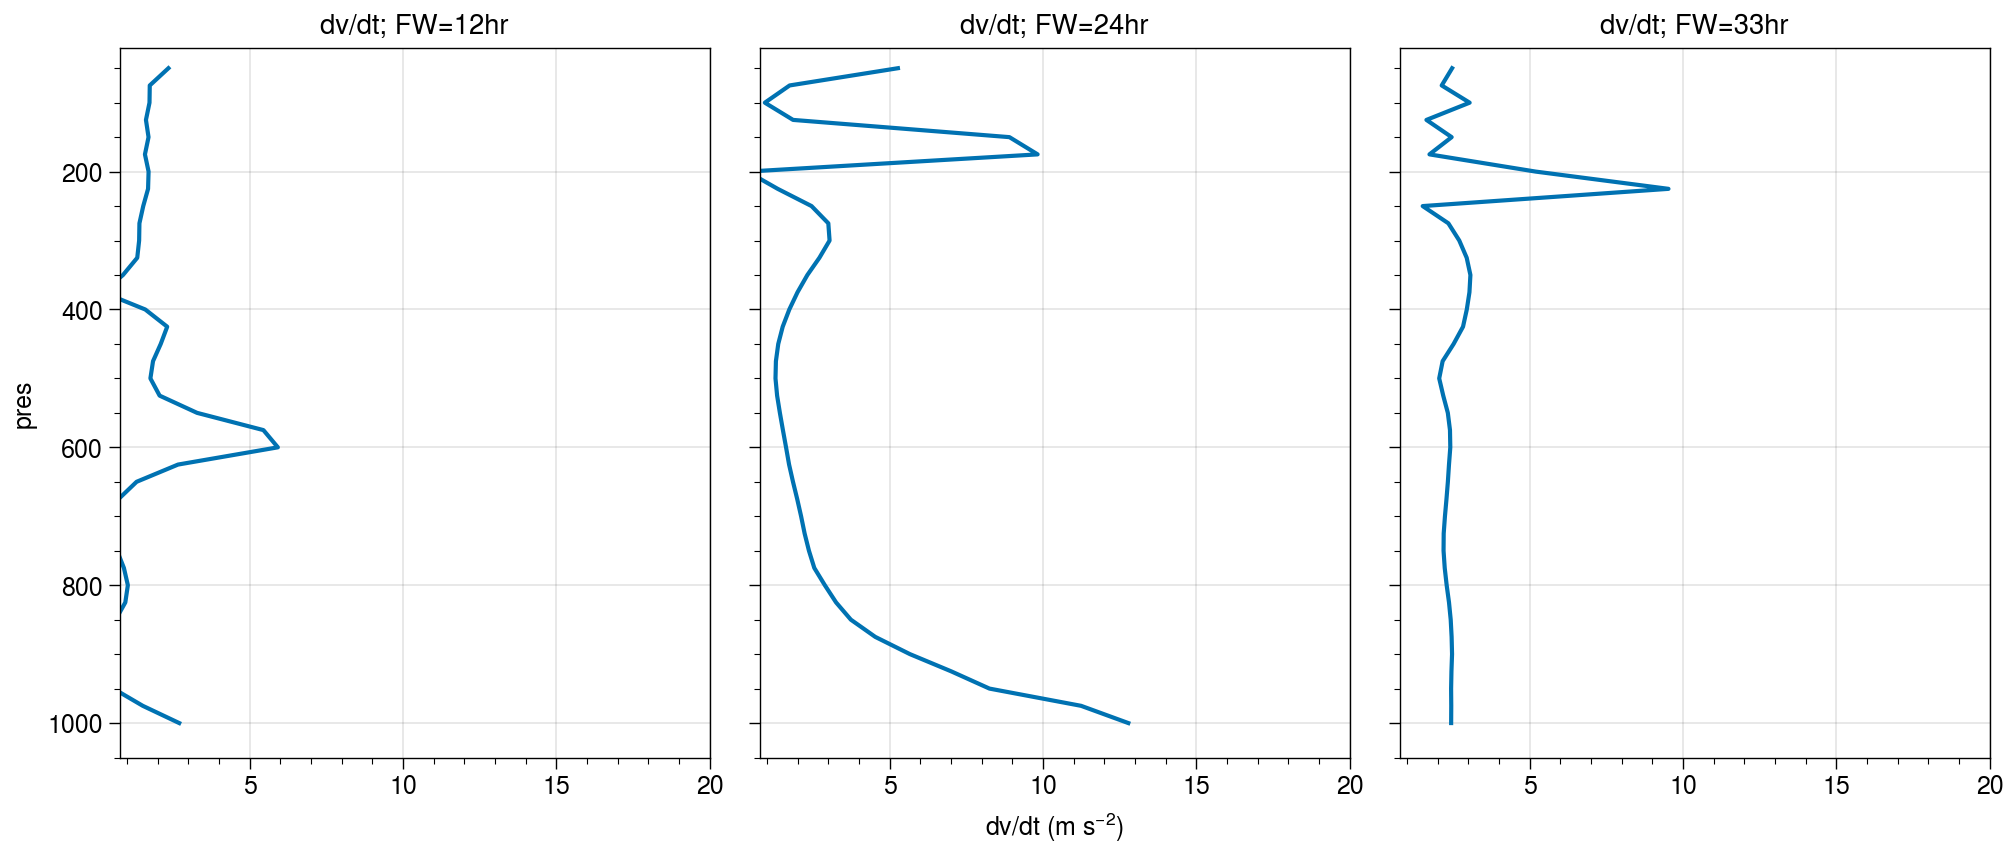

In [81]:
index =[3,6,9]
var='v'
#A = np.abs(np.nanmean(RECON_dict[var][index][:,:,0:],axis=(1,2))-\
#         np.nanmean(RAD_dict[var][index][:,:,0:]+RESI_dict[var][index][:,:,0:]+UVW_dict[var][index][:,:,0:],axis=(1,2)))

fig,axs = plot.subplots(ncols=3,nrows=1,axwidth=2.95,refaspect=0.831)
A = np.abs(np.nanmean(RECON_dict[var][index[0]][:,:,0:],axis=(1,2))-\
         np.nanmean(RAD_dict[var][index[0]][:,:,0:]+RESI_dict[var][index[0]][:,:,0:]+UVW_dict[var][index[0]][:,:,0:],axis=(1,2)))
axs[0].plot(np.abs(np.nanmean(RAD_dict[var][index[0]][:,:,0:],axis=(1,2)))/A,coor.pres)
axs[0].format(xlabel='d'+str(var)+'/dt (m s$^{-2}$)',ylabel='Pressure (hPa)',title='d'+str(var)+'/dt; FW=12hr',ylim=[1050,20],xlim=[0.75,20])

A = np.abs(np.nanmean(RECON_dict[var][index[1]][:,:,0:],axis=(1,2))-\
         np.nanmean(RAD_dict[var][index[1]][:,:,0:]+RESI_dict[var][index[1]][:,:,0:]+UVW_dict[var][index[1]][:,:,0:],axis=(1,2)))
axs[1].plot(np.abs(np.nanmean(RAD_dict[var][index[1]][:,:,0:],axis=(1,2)))/A,coor.pres,label=r'$\dot{\theta_{rad}}$')
axs[1].format(title='d'+str(var)+'/dt; FW=24hr',xlim=[0.75,20])

A = np.abs(np.nanmean(RECON_dict[var][index[2]][:,:,0:],axis=(1,2))-\
         np.nanmean(RAD_dict[var][index[2]][:,:,0:]+RESI_dict[var][index[2]][:,:,0:]+UVW_dict[var][index[2]][:,:,0:],axis=(1,2)))
axs[2].plot(np.abs(np.nanmean(RAD_dict[var][index[2]][:,:,0:],axis=(1,2)))/A,coor.pres,label=r'$\dot{\theta_{rad}}$')
axs[2].format(title='d'+str(var)+'/dt; FW=33hr',xlim=[0.75,20])
plt.savefig('./proc_fig/0118/heat decomposition/d'+str(var)+'dt_ratio',dpi=400)
plt.show()

#### Trace intensification

In [90]:
testtrace = np.diff(np.stack([RAD_dict['v'][i][0,:,:] for i in range(len(RAD_dict['v']))],axis=0),axis=0)
testtrace2 = np.diff(np.stack([RESI_dict['v'][i][0,:,:] for i in range(len(RESI_dict['v']))],axis=0),axis=0)
testtrace3 = np.diff(np.stack([HEAT_dict['v'][i][0,:,:] for i in range(len(HEAT_dict['v']))],axis=0),axis=0)

In [93]:
testint,testint2,testint3 = [],[],[]
for i in tqdm(range(12)):
    testint.append(np.trapz(testtrace[0:int(i),:,:],axis=0,dx=3*60*60))
    testint2.append(np.trapz(testtrace2[0:int(i),:,:],axis=0,dx=3*60*60))
    testint3.append(np.trapz(testtrace3[0:int(i),:,:],axis=0,dx=3*60*60))

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 109.57it/s]


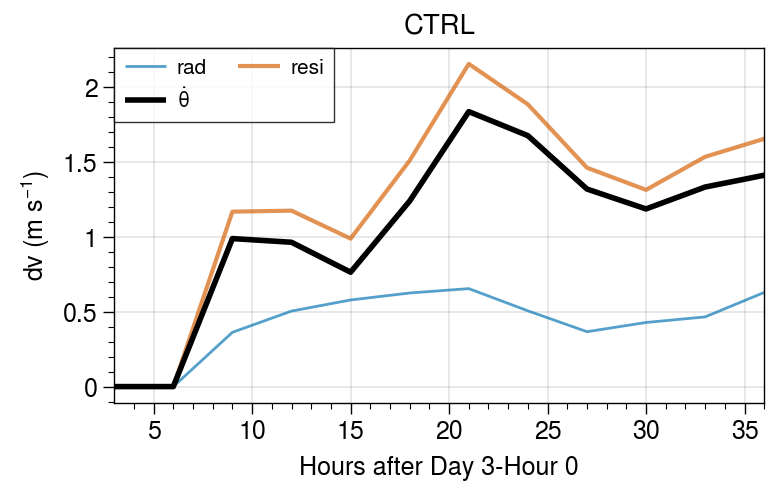

In [94]:
fig,axs = plot.subplots(ncols=1,nrows=1,axwidth=3.25,refaspect=1.831)
axs[0].plot([3,6,9,12,15,18,21,24,27,30,33,36],[np.max(testint[i]) for i in range(12)],label='rad',lw=1,alpha=0.67)
axs[0].plot([3,6,9,12,15,18,21,24,27,30,33,36],[np.max(testint2[i]) for i in range(12)],label='resi',lw=1.5,alpha=0.67)
axs[0].plot([3,6,9,12,15,18,21,24,27,30,33,36],[np.max(testint3[i]) for i in range(12)],label=r'$\dot{\theta}$',lw=2,c='k')
axs[0].legend(loc='ul',ncols=2,prop={'size':7.5})
axs[0].format(ylabel='dv (m s$^{-1}$)',xlabel='Hours after Day 3-Hour 0',title='CTRL')
plt.savefig('./proc_fig/0118/d'+str(var)+'_heat',dpi=400)
plt.show()

#### Plotting codes

KeyboardInterrupt: 

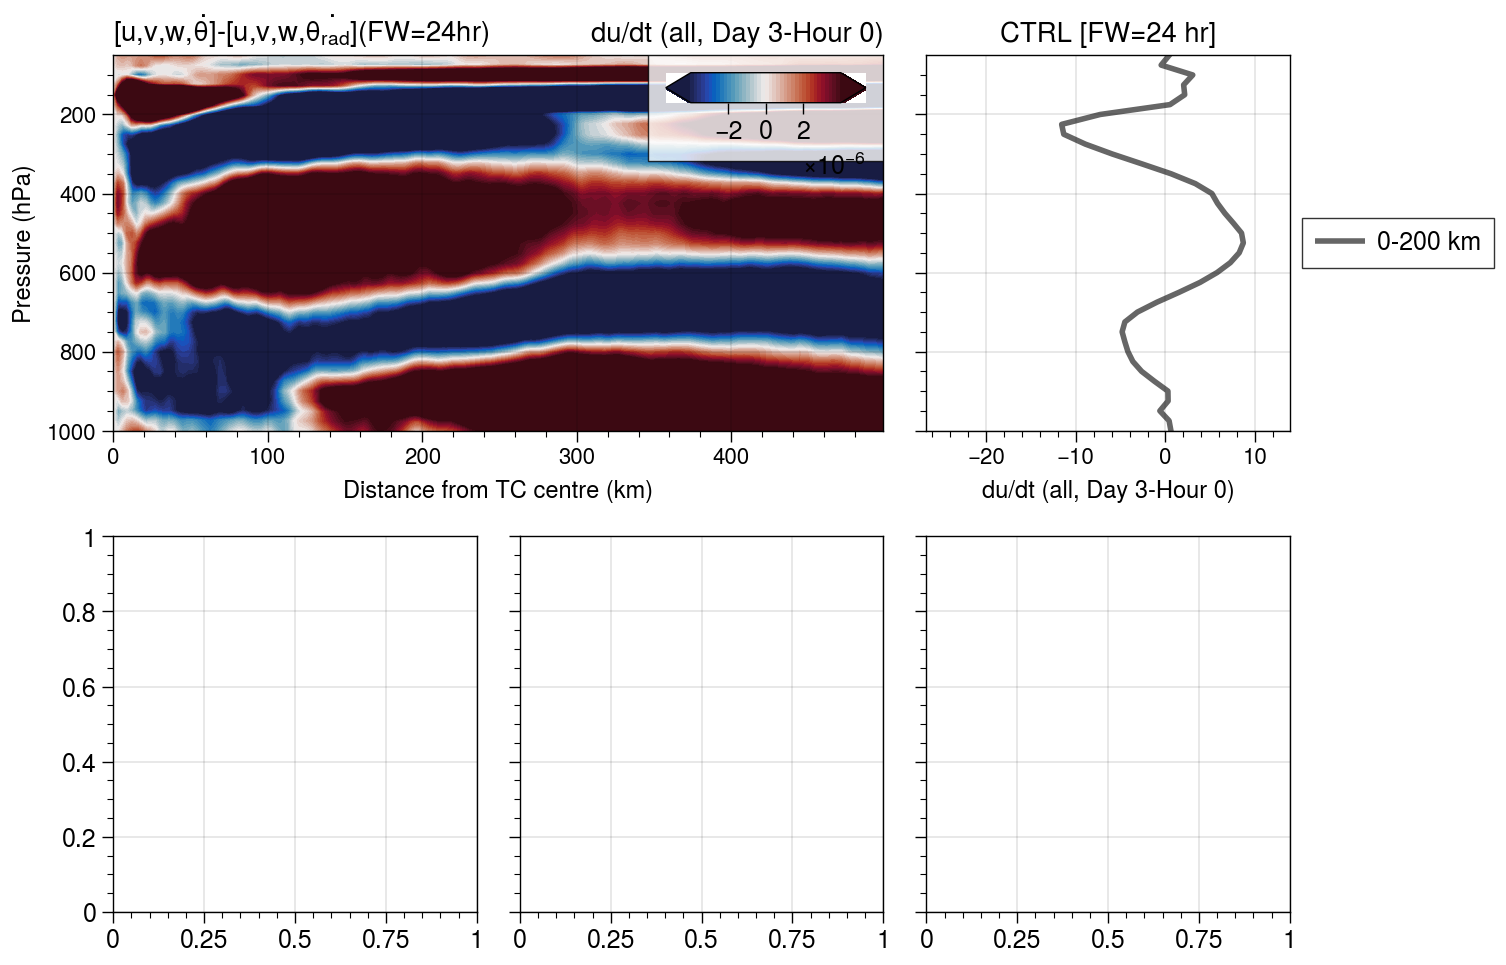

In [10]:
ANGLE = azimuth2angle(np.linspace(0,359,360))
NEWCART_axis = np.concatenate((np.flipud(-ctrlvar_dict['U10'].radius[:r500]),ctrlvar_dict['U10'].radius[:r500][:]))
path_coor = '/scratch/06040/tg853394/tc/output/redux/maria/ctl/post/U.nc'
coor = xr.open_dataset(path_coor)
sensitivity='No'
if sensitivity=='Yes':
    # (index(last CTRL,LT=1)-newLT_clearterms)+(target_index-36)
    index = (94-11)+(48-36)
else:
    index = 48
############################################################################################################################################
array = [[1, 1, 2],[3, 4, 5]]
plotcomp2=1
plotarray = RECON_dict['u'][7]
setting = [np.linspace(-4e-6,4e-6,41),[-2e-6,0,2e-6]]
#setting = [np.linspace(-0.5e-6,0.5e-6,41),[-0.25e-6,0,0.25e-6]]
#plotarray = np.nanmean(np.nanmean(RECON_dict['u'][0][12:12+48,:],axis=0).reshape(39,360,167),axis=1)
#plotlabel = r'dw/dt (PCA0'+str(plotcomp2+1)+', Day 3-Hour 0)'
plotlabel = r'du/dt (all, Day 3-Hour 0)'
fig,axs = plot.subplots(array,axwidth=3.85,refaspect=2.051,span=False,sharex=False)
display_crosssection(np.nanmean(plotarray,axis=1),ctrlvar_dict['U10'].radius[:r500],coor.pres,plotcomp2,
                     None,axs[0],plotlabel,setting[0],setting[1],True,\
                     r'[u,v,w,$\dot{\theta}$]-[u,v,w,$\dot{\theta_{rad}}$](FW=24hr)')
display_avgprofil(plotarray/1e-6,coor.pres,plotcomp2,False,[0,r200,r500],axs[1],plotlabel,['k','r'],2,0.6,True,'CTRL [FW=24 hr]')
display_cart(plotarray/1e-6,[axs[2],axs[3],axs[4]],plotcomp2,[6,20,32],NEWCART_axis,ANGLE)
#plt.savefig('./reconstructure_dwdt_dthdt_PCA0'+str(plotcomp2+1)+'_3hr_Day3hr0.png',dpi=400)
plt.savefig('../0105/reconstructure_dudt_RESI_24hr_Day3hr0.png',dpi=400)
plt.show()
# w:np.linspace(-10e-6,10e-6,41),[-6e-6,0,6e-6] / u,v np.linspace(-6e-5,6e-5,41),[-3e-5,0,3e-5]

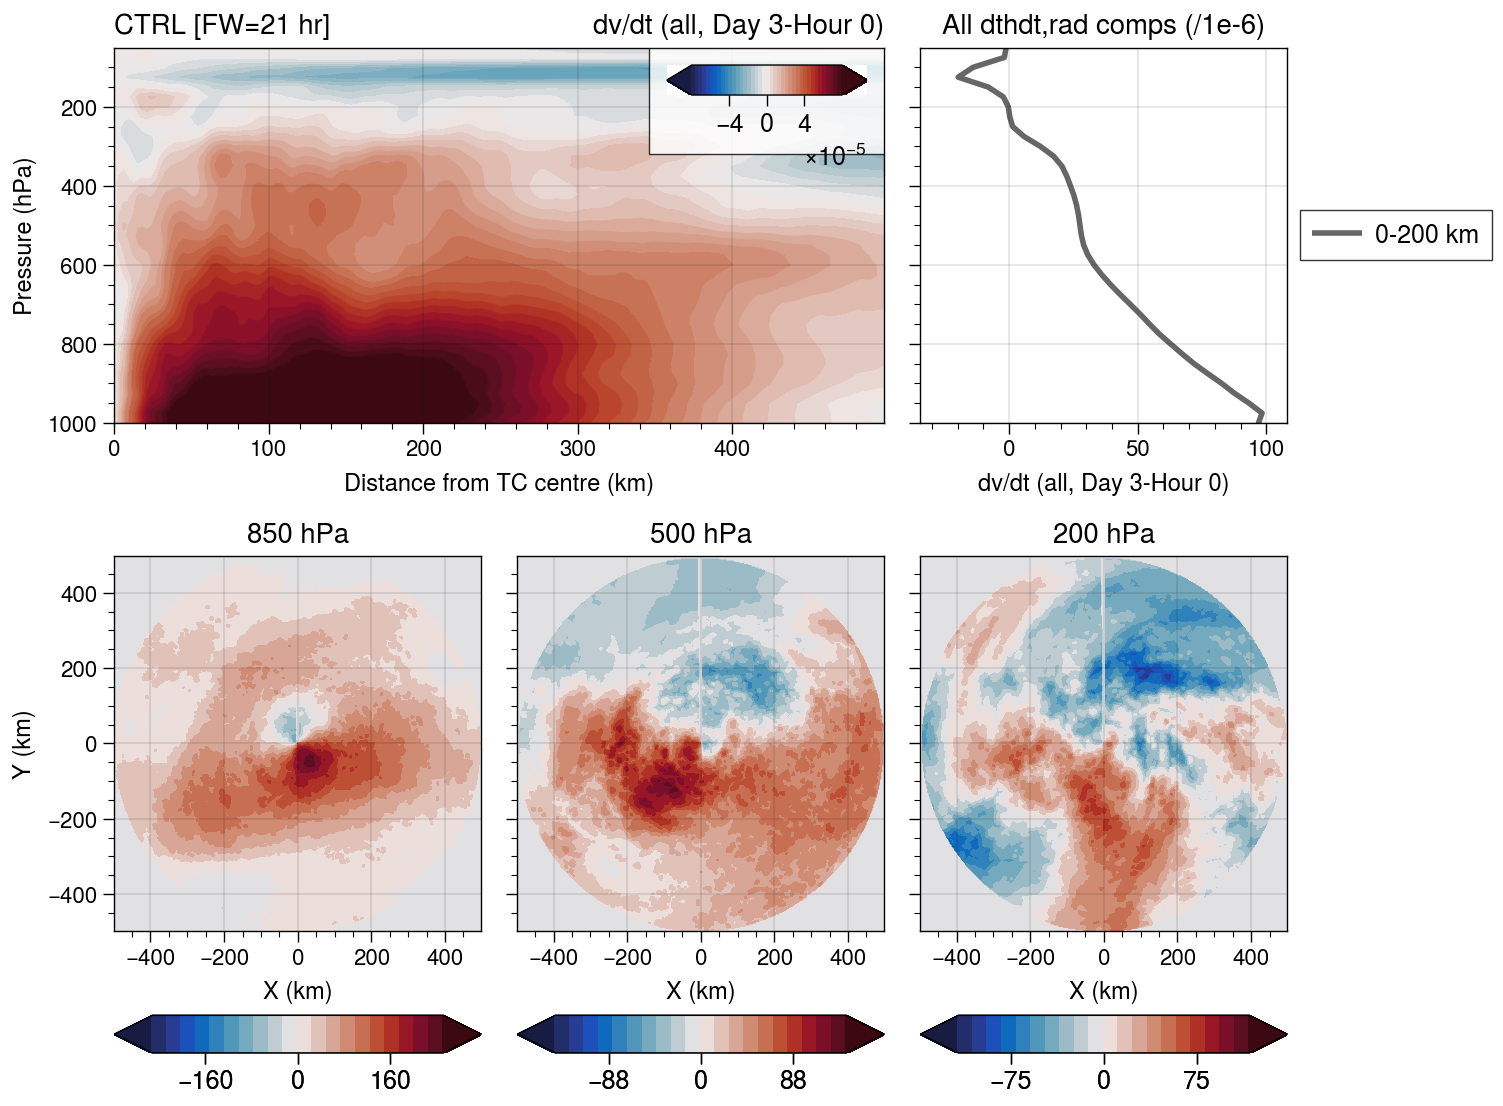

In [21]:
############################################################################################################################################
ANGLE = azimuth2angle(np.linspace(0,359,360))
NEWCART_axis = np.concatenate((np.flipud(-ctrlvar_dict['U10'].radius[:r500]),ctrlvar_dict['U10'].radius[:r500][:]))
path_coor = '/scratch/06040/tg853394/tc/output/redux/maria/ctl/post/U.nc'
coor = xr.open_dataset(path_coor)
sensitivity='No'
if sensitivity=='Yes':
    # (index(last CTRL,LT=1)-newLT_clearterms)+(target_index-36)
    index = (94-11)+(48-36)
else:
    index = 48
############################################################################################################################################
array = [[1, 1, 2],[3, 4, 5]]
plotcomp2=2
plotarray = RECON_dict['v'][6]
#plotarray = np.nanmean(np.nanmean(RECON_dict['u'][0][12:12+48,:],axis=0).reshape(39,360,167),axis=1)
#plotlabel = r'dw/dt (PCA0'+str(plotcomp2+1)+', Day 3-Hour 0)'
plotlabel = r'dv/dt (all, Day 3-Hour 0)'
fig,axs = plot.subplots(array,axwidth=3.85,refaspect=2.051,span=False,sharex=False)
display_crosssection(np.nanmean(plotarray,axis=1),ctrlvar_dict['U10'].radius[:r500],coor.pres,plotcomp2,
                     None,axs[0],plotlabel,np.linspace(-8e-5,8e-5,41),[-4e-5,0,4e-5],True,'CTRL [FW=21 hr]')
display_avgprofil(plotarray/1e-6,coor.pres,plotcomp2,False,[0,r200,r500],axs[1],plotlabel,['k','r'],2,0.6,True,'All dthdt,rad comps (/1e-6)')
display_cart(plotarray/1e-6,[axs[2],axs[3],axs[4]],plotcomp2,[6,20,32],NEWCART_axis,ANGLE)
#plt.savefig('./reconstructure_dwdt_dthdt_PCA0'+str(plotcomp2+1)+'_3hr_Day3hr0.png',dpi=400)
plt.savefig('../0105/60/reconstructure_dvdt_ALL_21hr_Day3hr0.png',dpi=400)
plt.show()
# w:np.linspace(-10e-6,10e-6,41),[-6e-6,0,6e-6] / u,v np.linspace(-6e-5,6e-5,41),[-3e-5,0,3e-5]

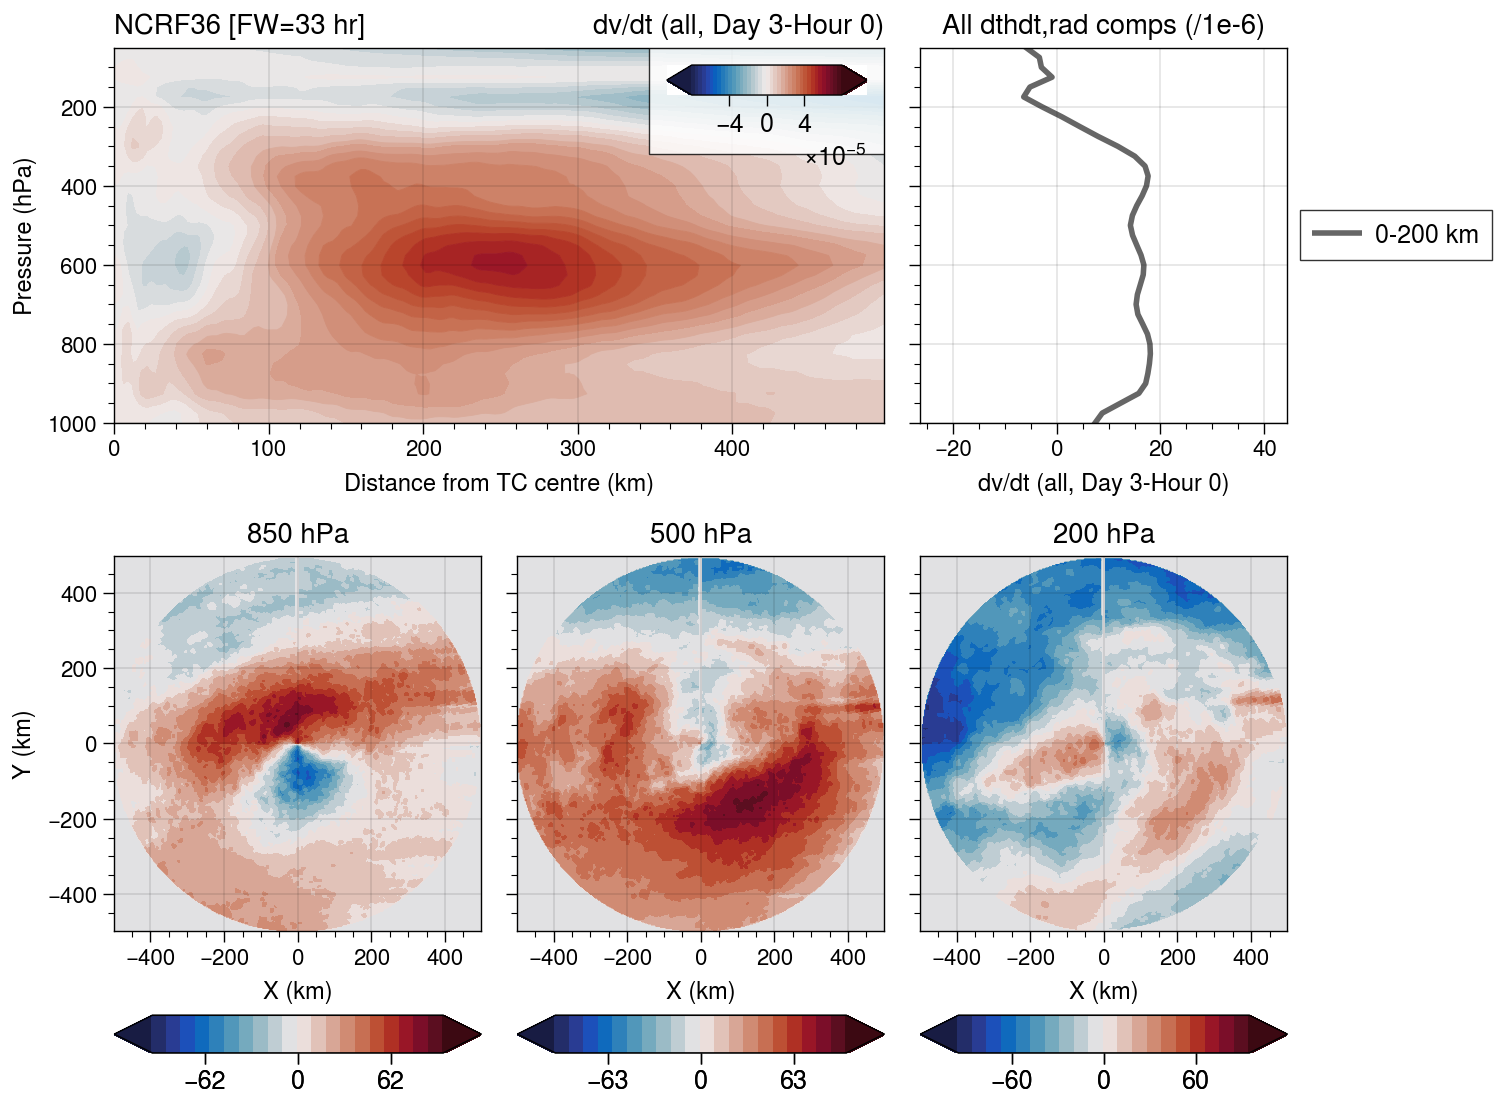

In [27]:
############################################################################################################################################
ANGLE = azimuth2angle(np.linspace(0,359,360))
NEWCART_axis = np.concatenate((np.flipud(-ctrlvar_dict['U10'].radius[:r500]),ctrlvar_dict['U10'].radius[:r500][:]))
path_coor = '/scratch/06040/tg853394/tc/output/redux/maria/ctl/post/U.nc'
coor = xr.open_dataset(path_coor)
sensitivity='No'
if sensitivity=='Yes':
    # (index(last CTRL,LT=1)-newLT_clearterms)+(target_index-36)
    index = (94-11)+(48-36)
else:
    index = 48
############################################################################################################################################
array = [[1, 1, 2],[3, 4, 5]]
plotcomp2=1
plotarray = RECON_dict['v'][10]
#plotarray = np.nanmean(np.nanmean(RECON_dict['u'][0][12:12+48,:],axis=0).reshape(39,360,167),axis=1)
#plotlabel = r'dw/dt (PCA0'+str(plotcomp2+1)+', Day 3-Hour 0)'
plotlabel = r'dv/dt (all, Day 3-Hour 0)'
fig,axs = plot.subplots(array,axwidth=3.85,refaspect=2.051,span=False,sharex=False)
display_crosssection(np.nanmean(plotarray,axis=1),ctrlvar_dict['U10'].radius[:r500],coor.pres,plotcomp2,
                     None,axs[0],plotlabel,np.linspace(-8e-5,8e-5,41),[-4e-5,0,4e-5],True,'NCRF36 [FW=33 hr]')
display_avgprofil(plotarray/1e-6,coor.pres,plotcomp2,False,[0,r200,r500],axs[1],plotlabel,['k','r'],2,0.6,True,'All dthdt,rad comps (/1e-6)')
display_cart(plotarray/1e-6,[axs[2],axs[3],axs[4]],plotcomp2,[6,20,32],NEWCART_axis,ANGLE)
#plt.savefig('./reconstructure_dwdt_dthdt_PCA0'+str(plotcomp2+1)+'_3hr_Day3hr0.png',dpi=400)
plt.savefig('../0105/60/reconstructure_dvdt_ALL_33hr_ncrf36_Day3hr0.png',dpi=400)
plt.show()
# w:np.linspace(-10e-6,10e-6,41),[-6e-6,0,6e-6] / u,v np.linspace(-6e-5,6e-5,41),[-3e-5,0,3e-5]

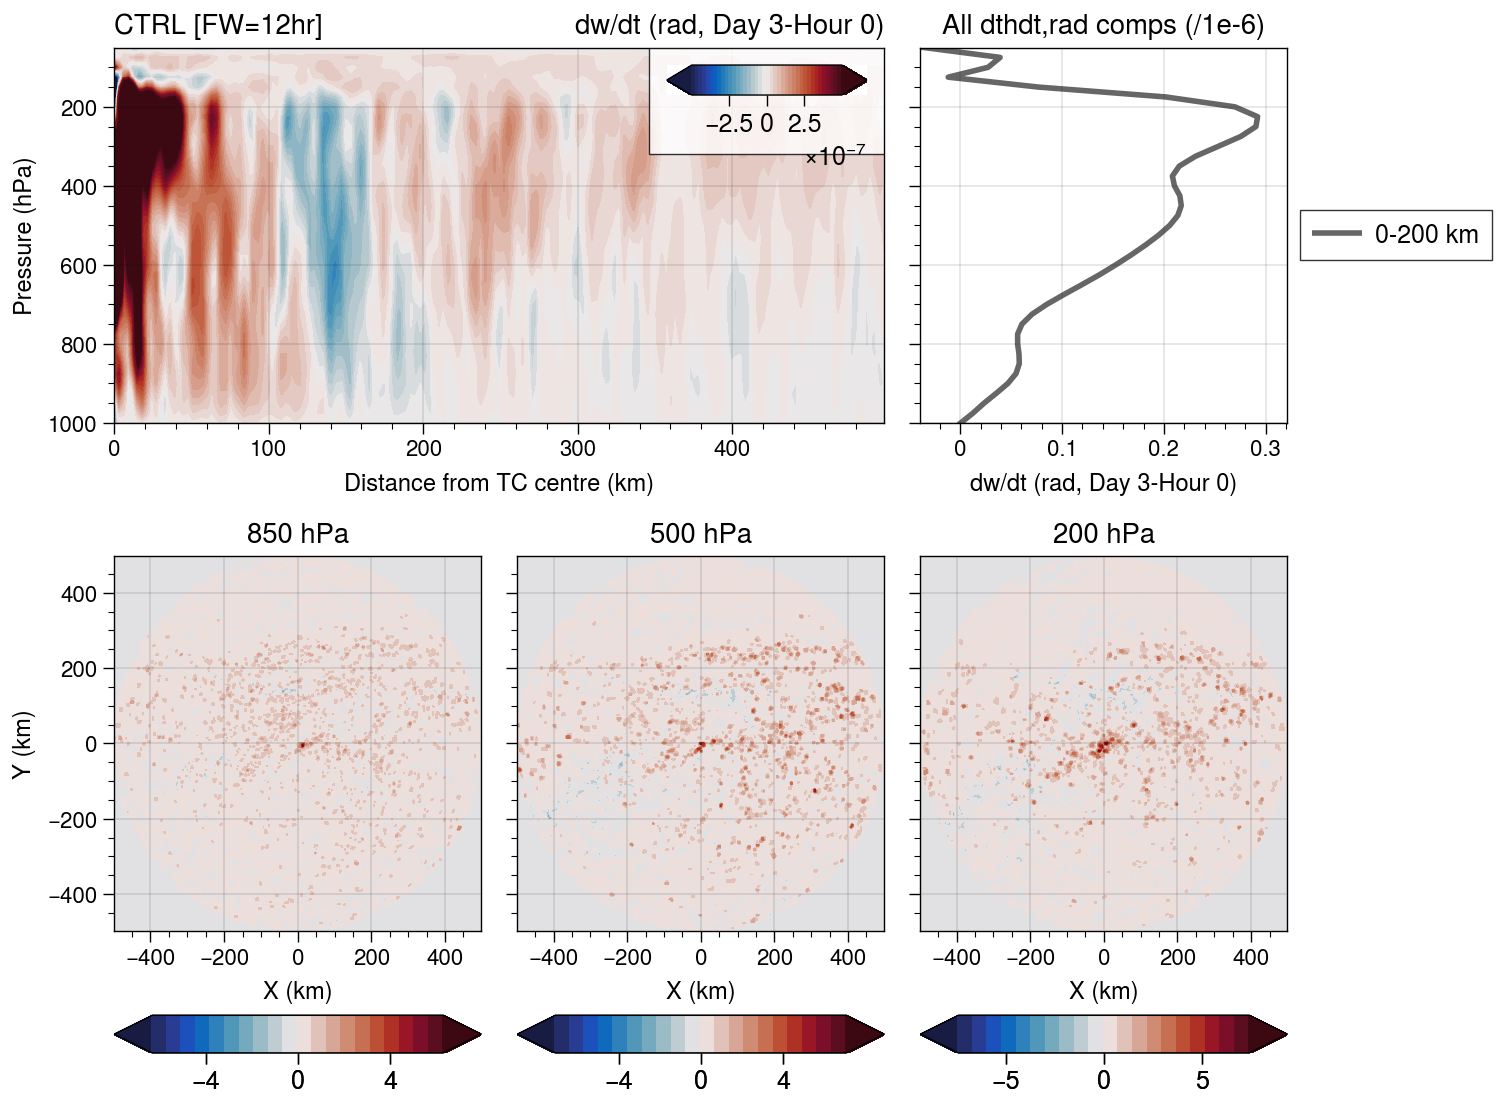

In [30]:
############################################################################################################################################
ANGLE = azimuth2angle(np.linspace(0,359,360))
NEWCART_axis = np.concatenate((np.flipud(-ctrlvar_dict['U10'].radius[:r500]),ctrlvar_dict['U10'].radius[:r500][:]))
path_coor = '/scratch/06040/tg853394/tc/output/redux/maria/ctl/post/U.nc'
coor = xr.open_dataset(path_coor)
sensitivity='No'
if sensitivity=='Yes':
    # (index(last CTRL,LT=1)-newLT_clearterms)+(target_index-36)
    index = (94-11)+(48-36)
else:
    index = 48
############################################################################################################################################
array = [[1, 1, 2],[3, 4, 5]]
plotcomp2=1
plotarray = RECON_dict['w'][3]
#plotarray = np.nanmean(np.nanmean(RECON_dict['u'][0][12:12+48,:],axis=0).reshape(39,360,167),axis=1)
#plotlabel = r'dw/dt (PCA0'+str(plotcomp2+1)+', Day 3-Hour 0)'
plotlabel = r'dw/dt (rad, Day 3-Hour 0)'
fig,axs = plot.subplots(array,axwidth=3.85,refaspect=2.051,span=False,sharex=False)
display_crosssection(np.nanmean(plotarray,axis=1),ctrlvar_dict['U10'].radius[:r500],coor.pres,plotcomp2,
                     None,axs[0],plotlabel,np.linspace(-0.5e-6,0.5e-6,41),[-0.25e-6,0,0.25e-6],True,'CTRL [FW=12hr]')
display_avgprofil(plotarray/1e-6,coor.pres,plotcomp2,False,[0,r200,r500],axs[1],plotlabel,['k','r'],2,0.6,True,'All dthdt,rad comps (/1e-6)')
display_cart(plotarray/1e-6,[axs[2],axs[3],axs[4]],plotcomp2,[6,20,32],NEWCART_axis,ANGLE)
#plt.savefig('./reconstructure_dwdt_dthdt_PCA0'+str(plotcomp2+1)+'_3hr_Day3hr0.png',dpi=400)
plt.savefig('../0105/reconstructure_dwdt_RAD_12hr_Day3hr0.png',dpi=400)
plt.show()
# w:np.linspace(-10e-6,10e-6,41),[-6e-6,0,6e-6] / u,v np.linspace(-6e-5,6e-5,41),[-3e-5,0,3e-5]